# 3D Image Segmentation with a 2D UNET

# 1) Imports and mount

In [1]:
# Notebook Setups
%load_ext autoreload
%autoreload 2

import os

# make root project the cwd
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(format=' %(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
import os, glob
from os import path

import nibabel as nib
import numpy as np
import cv2
import os.path
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt

from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.inferers import SlidingWindowInferer

from monai.data import Dataset, DataLoader
from src.enums import INTERIM_TRAINING_DATA_PATHS
from src.features.build_features import train_transform, val_transform, test_transform

from src.enums import DataDict, CountryDirType
from src.visualization.visualize import view_slice



# 2) Helper Functions and Global Variables

## 3.1) Sample Data

Get slices and save into a list dicts

In [3]:
from src.enums import INTERIM_TRAINING_DATA_PATHS, INTERIM_TESTING_DATA_PATHS
from src.utils import get_interim_data_path

interim_train_paths = get_interim_data_path(INTERIM_TRAINING_DATA_PATHS)
interim_test_paths = get_interim_data_path(INTERIM_TESTING_DATA_PATHS)

## 3.3) Transforms

In [4]:
SEED = 2
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 64

## 3.5) Dataset and Dataloader

In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
train_paths = get_interim_data_path(INTERIM_TRAINING_DATA_PATHS)
val_paths = get_interim_data_path(INTERIM_TESTING_DATA_PATHS)

train_dataset  = Dataset(train_paths, train_transform)
validation_dataset  = Dataset(val_paths, val_transform)
test_dataset = Dataset(val_paths, test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE_VAL, shuffle=True)

In [7]:
from monai.transforms import LoadImaged

paths = [{
    DataDict.Id: 12,
    DataDict.Image: "data/interim/training/Singapore/51/Image/T1/brain_51-slice022_z.nii.gz",
    DataDict.ImageFlair:"data/interim/training/Singapore/51/Image/Flair/brain_51-slice022_z.nii.gz",
    DataDict.ImageT1: "data/interim/training/Singapore/51/Image/T1/brain_51-slice022_z.nii.gz",
    DataDict.Label:"data/interim/training/Singapore/51/Label/T1/brain_51-slice022_z.nii.gz",
    DataDict.DepthZ: 22
}]
test = Dataset(train_paths, train_transform)
train_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True, num_workers=2)

In [8]:

sample_data = test.__getitem__(20)

c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:494: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 1,please make sure the input is in the channel-first format.
  warnings.warn(
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 2,please make sure the input is in the channel-first format.
  warnings.warn(


1920
tensor([[[1.8410e-04, 1.8410e-04, 1.8410e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.8410e-04, 1.8410e-04, 1.8410e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.8410e-04, 1.8410e-04, 1.8410e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [8.0834e-04, 8.0834e-04, 8.0834e-04,  ..., 5.5304e-05,
          5.5304e-05, 5.5304e-05],
         [8.0834e-04, 8.0834e-04, 8.0834e-04,  ..., 5.5304e-05,
          5.5304e-05, 5.5304e-05],
         [8.0834e-04, 8.0834e-04, 8.0834e-04,  ..., 5.5304e-05,
          5.5304e-05, 5.5304e-05]]])

Shapes: 
Image torch.Size([2, 256, 256]) 
Flair torch.Size([1, 256, 256])
T1 torch.Size([1, 256, 256])
Label torch.Size([2, 256, 256])

T1: Min:0.0 Max: 0.44478482007980347


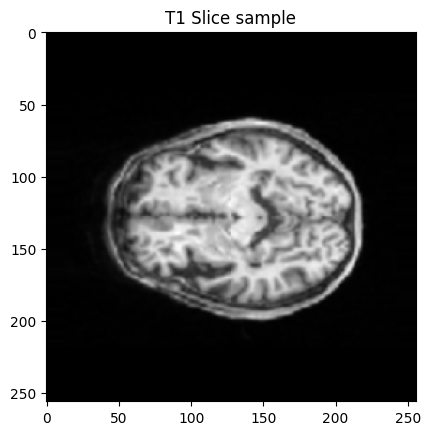

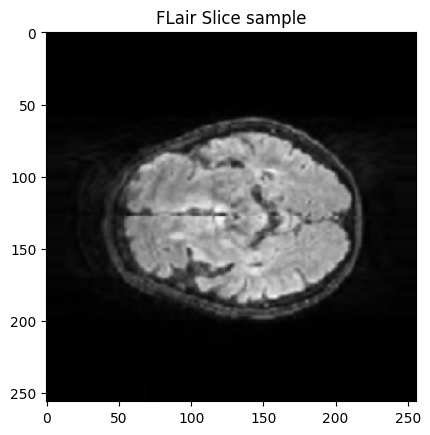

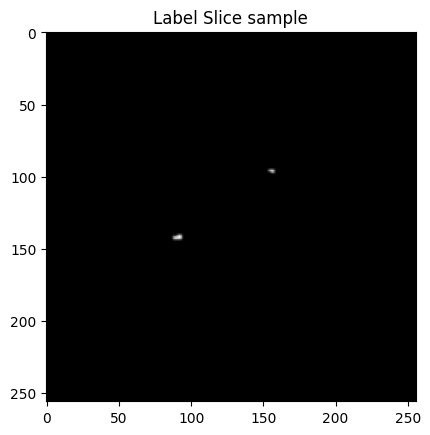

In [9]:


print(len(train_loader))

sample_data = test.__getitem__(20)
sample_tensor_image, sample_tensor_flair, sample_tensor_t1, sample_tensor_label = sample_data[DataDict.Image], sample_data[DataDict.ImageFlair], sample_data[DataDict.ImageT1], sample_data[DataDict.Label]

print(f'{sample_tensor_flair}\n')
print(f'Shapes: \nImage {sample_tensor_image.shape} \nFlair {sample_tensor_flair.shape}\nT1 {sample_tensor_t1.shape}\nLabel {sample_tensor_label.shape}\n')

print(f"T1: Min:{torch.min(sample_tensor_t1)} Max: {torch.max(sample_tensor_t1)}")

view_slice(sample_tensor_image[0].squeeze().detach().cpu(), "T1 Slice sample", True)
view_slice(sample_tensor_image[1].squeeze().detach().cpu(), "FLair Slice sample", True)
view_slice(sample_tensor_label[1].squeeze().detach().cpu(), "Label Slice sample", True)

Shapes: 
Image torch.Size([2, 256, 256]) 
Flair torch.Size([1, 256, 256])
T1 torch.Size([1, 256, 256])
Label torch.Size([2, 256, 256])


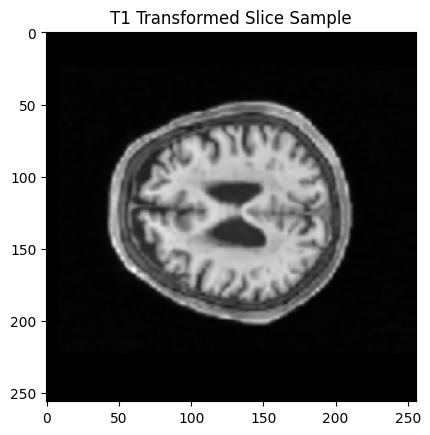

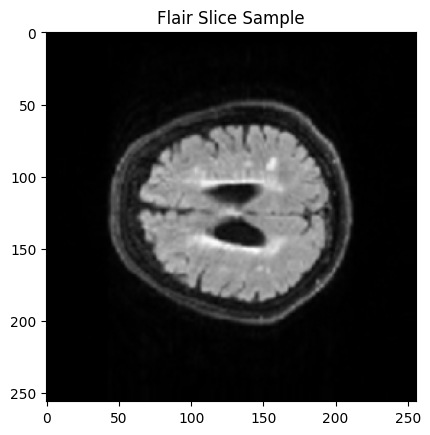

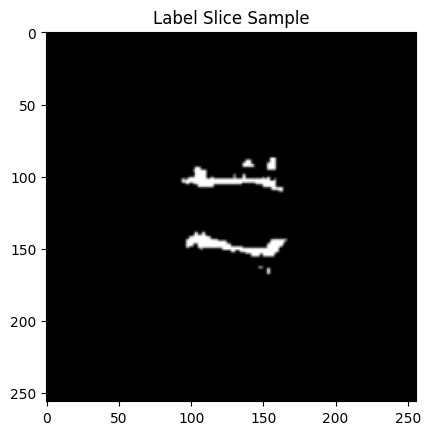

In [10]:
sample_data_2 = train_dataset.__getitem__(320)
sample_tensor_image2, sample_tensor_flair2, sample_tensor_t12, sample_tensor_label2 = sample_data_2[DataDict.Image], sample_data_2[DataDict.ImageFlair], sample_data_2[DataDict.ImageT1], sample_data_2[DataDict.Label]

print(f'Shapes: \nImage {sample_tensor_image2.shape} \nFlair {sample_tensor_flair2.shape}\nT1 {sample_tensor_t12.shape}\nLabel {sample_tensor_label2.shape}')
view_slice(sample_tensor_image2[0].squeeze().detach().cpu(), "T1 Transformed Slice Sample", True)
view_slice(sample_tensor_image2[1].squeeze().detach().cpu(), "Flair Slice Sample", True)
view_slice(sample_tensor_label2[1].squeeze().detach().cpu(), "Label Slice Sample", True)

# 4) Network

## 4.1) Train Network

## 4.3) Train data

In [11]:
from src.models.train_model import ModelTrainer, model, loss_function, optimizer, device
summary(model, (2, 256, 256))

ImportError: cannot import name 'train_network' from 'src.models.train_model' (c:\Users\zifen\Documents\Projects\wmh-segmentation\src\models\train_model.py)

In [ ]:
model_trainer = ModelTrainer(
        model,
        train_loader,
        validation_loader,
    loss_function, optimizer, device, 2000, False, ""
)
net = model_trainer.train_model()

losses: {}
val losses {}
Epoch 0	Training Step: 1/1920


c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\torch\_tensor.py:1386: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


Epoch 0	Training Step: 2/1920
Epoch 0	Training Step: 3/1920
Epoch 0	Training Step: 4/1920
Epoch 0	Training Step: 5/1920
Epoch 0	Training Step: 6/1920
Epoch 0	Training Step: 7/1920
Epoch 0	Training Step: 8/1920
Epoch 0	Training Step: 9/1920
Epoch 0	Training Step: 10/1920
Epoch 0	Training Step: 11/1920
Epoch 0	Training Step: 12/1920
Epoch 0	Training Step: 13/1920
Epoch 0	Training Step: 14/1920
Epoch 0	Training Step: 15/1920
Epoch 0	Training Step: 16/1920
Epoch 0	Training Step: 17/1920
Epoch 0	Training Step: 18/1920
Epoch 0	Training Step: 19/1920
Epoch 0	Training Step: 20/1920
Epoch 0	Training Step: 21/1920
Epoch 0	Training Step: 22/1920
Epoch 0	Training Step: 23/1920
Epoch 0	Training Step: 24/1920
Epoch 0	Training Step: 25/1920
Epoch 0	Training Step: 26/1920
Epoch 0	Training Step: 27/1920
Epoch 0	Training Step: 28/1920
Epoch 0	Training Step: 29/1920
Epoch 0	Training Step: 30/1920
Epoch 0	Training Step: 31/1920
Epoch 0	Training Step: 32/1920
Epoch 0	Training Step: 33/1920
Epoch 0	Training

KeyboardInterrupt: 

# 5) Test network

In [ ]:
# Load the network for testing
pred_network = model

checkpoint = torch.load('models/test.pt', map_location=torch.device('cpu'))
epoch_checkpoint = checkpoint['epoch']
losses = checkpoint['losses']
val_losses = checkpoint['val_losses']
pred_network.load_state_dict(checkpoint['model_state_dict'])

# print(checkpoint['model_state_dict'])
print(epoch_checkpoint)
print(losses)
print(val_losses)



In [ ]:
from src.utils import dict_tensor_to_value
print(losses)
print(val_losses)


# Plot the validation and training losses
print(val_losses)
val_tensors = dict_tensor_to_value(val_losses)
print(val_tensors)

training_losses = sorted(losses.items()) # sorted by key, return a list of tuples
x, y = zip(*training_losses) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

validation_losses = sorted(val_tensors.items())
x2, y2 = zip(*validation_losses) # unpack a list of pairs into two tuples

plt.plot(x2, y2)
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(x, y, label = "Training")
plt.plot(x2, y2, label = "Validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from torchvision import models
from torchsummary import summary

summary(pred_network, (2, 256, 256))

# 6) Test Whole Volume

In [ ]:
class ImagePredictor():
    def __init__(self, model, dataset):
        self.model = model
        # Passed as 2D slices with information about depth for reconstruction
        self.dataset = dataset

    def predict(self):
        self.slice_predictions = []
        with torch.no_grad():
            self.model.eval()
            pred_count = 1

            for data in self.dataset:
                if pred_count == 1 or pred_count % 50 == 0 or pred_count == len(self.dataset):
                    print(f'Predicting {pred_count}/{len(self.dataset)} slices')
                image = data[DataDict.Image]
                label = data[DataDict.Label]
                subj_id = data[DataDict.Id]
                depth_z = data[DataDict.DepthZ]

                image = image.unsqueeze(dim=0)
                image = image.to(device)

                output = one_hot(self.model(image))

                self.slice_predictions.append({
                    DataDict.Id: subj_id,
                    DataDict.DepthZ: depth_z,
                    DataDict.Label: label,
                    DataDict.Prediction: output
                })

                # print(self.slice_predictions)

                pred_count += 1
                

    def predict_handler(self):
        # Predict all slices
        self.predict()
        self.volume_predictions = []

        subj_ids = list(set(list(v[DataDict.Id] for v in self.slice_predictions)))

        print(f'{len(subj_ids)} subjects to predict')
        pred_count = 1
        # For all subjects
        for subject_id in subj_ids:
            print(f'Reconstructing {pred_count}/{len(subj_ids)}')
            # Find all slice_predictions by subjects
            subject_predictions = get_dicts_from_dicts(self.slice_predictions, DataDict.Id, [subject_id])
          
            # Reconstruct volume by subject
            volume_prediction, volume_label = self.reconstruct(subject_predictions)
        
            self.volume_predictions.append({
                DataDict.Id: subject_id,
                DataDict.Prediction: volume_prediction,
                DataDict.Label: volume_label
            })

            pred_count += 1

        return self.volume_predictions

    def reconstruct(self, subj_predictions):
        # sorted_subbj_pred_by_depth = sorted(subj_predictions, key=itemgetter(DataDict.DepthZ))     
        z_length = len(subj_predictions)  
        prediction_volume = torch.zeros((256, 256, z_length))
        label_volume = torch.zeros((256, 256, z_length))
        subj_id = subj_predictions[0][DataDict.Id]

        for i in range(z_length):
            # only take second channel
            if subj_predictions[i][DataDict.DepthZ] != i:
                raise ValueError("Reconstruction error: Slice missing") 

            subj_slice = subj_predictions[i] 
            # print(f'slice prediction {subj_slice[DataDict.Prediction].shape}')
            # print(f'slice label {subj_slice[DataDict.Label].shape}')
            prediction_volume[..., i] = subj_slice[DataDict.Prediction][0, 1, ...]
            label_volume[..., i] = subj_slice[DataDict.Label][1]

        return prediction_volume, label_volume

In [ ]:
# test_datasaet
img_predictor = ImagePredictor(pred_network, test_dataset)
test_predictions = img_predictor.predict_handler()
print('DONE')

In [ ]:
len(test_predictions)

In [ ]:
from monai.metrics import compute_meandice, DiceMetric

dice_scores = []

for i in range(len(test_predictions)):
    test_subject_prediction = test_predictions[i]

    print(test_subject_prediction[DataDict.Label].shape)
    print(test_subject_prediction[DataDict.Prediction].shape)

    pred = test_subject_prediction[DataDict.Prediction]
    label = test_subject_prediction[DataDict.Label]

    print(torch.max(pred))
    print(torch.min(pred))

    dice_metric = DiceLoss()
    # print(compute_meandice(pred, label))
    dice_score = 1 - dice_metric(pred, label)

    dice_scores.append(dice_score.item())


In [ ]:
dice_scores


In [ ]:
from numpy import mean
mean_dice_score = round(mean(dice_scores), 5) 
mean_dice_score

In [ ]:
# view_slice(numpy_from_tensor(inputs[0, 0, :, :]), f'Input Channel 0 Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(inputs[0, 1, :, :]), f'Input Channel 1 Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(outputs[0, 1, :, :]), f'WMH Output Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(pred[..., 25]), f'WMH Pred', gray=True)
# view_slice(numpy_from_tensor(label[..., 25]), f'WMH Labels', gray=True)

w = 200
h = 200
fig = plt.figure(figsize=(200, 600))
fig.set_figheight(h)
fig.set_figwidth(w)
columns = 8
rows = 12

label_count = 0
pred_count = 0
row = 1

for i in range(1, columns * rows + 1):  
    fig.add_subplot(rows, columns, i)
    # Prediction row
    if row % 2 != 0:
        plt.subplot(rows, columns, i).set_title(f'Prediction Depth {pred_count}', fontweight="bold", size=80)
        plt.imshow(pred[..., pred_count], cmap='gray')
        pred_count += 1
    # Label row
    else:
        plt.subplot(rows, columns, i).set_title(f'Label Depth {label_count}', fontweight="bold", size=80)
        plt.imshow(label[..., label_count], cmap='gray')
        label_count += 1

    
    row += 1 if i % 8 == 0 else 0
plt.show()